In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.custom_dataset import GTSRBCustomDataset
from models.resnet_model import get_resnet_model
from utils.metrics import calculate_metrics, print_classification_report, get_confusion_matrix
from utils.plot_utils import plot_confusion_matrix

In [2]:
STRATEGY = "partial_finetune"
CHECKPOINT_PATH = f"outputs/checkpoints/resnet18_best_{STRATEGY}.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


In [4]:
test_dataset = GTSRBCustomDataset(
  csv_path="dataset/Test.csv",
  root_dir="dataset",
  transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64)

Loading CSV from: dataset/Test.csv
Dataset loaded: 12630 samples
Columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Validating image paths...
✓ Image 1 exists: Test/00000.png
✓ Image 2 exists: Test/00001.png
✓ Image 3 exists: Test/00002.png
✓ Image 4 exists: Test/00003.png
✓ Image 5 exists: Test/00004.png
✓ Image 6 exists: Test/00005.png
✓ Image 7 exists: Test/00006.png
✓ Image 8 exists: Test/00007.png
✓ Image 9 exists: Test/00008.png
✓ Image 10 exists: Test/00009.png


In [5]:
print(f"Loading ResNet model with strategy '{STRATEGY}'")
model = get_resnet_model(num_classes=43, strategy=STRATEGY)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE).eval()
print("Model loaded successfully")

Loading ResNet model with strategy 'partial_finetune'
Model loaded successfully


C:\Users\USER\AppData\Local\Temp\ipykernel_37384\2834523135.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

In [6]:
y_true = []
y_pred = []

In [7]:
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


Metrics:
Accuracy: 0.9856
Precision: 0.9788
Recall: 0.9804
F1_score: 0.9792

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.98      0.98      0.98       450
           4       1.00      0.99      0.99       660
           5       0.93      0.98      0.96       630
           6       0.99      0.90      0.94       150
           7       1.00      1.00      1.00       450
           8       1.00      0.94      0.97       450
           9       0.98      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       1.00      0.98      0.99       420
          12       1.00      0.99      1.00       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00 

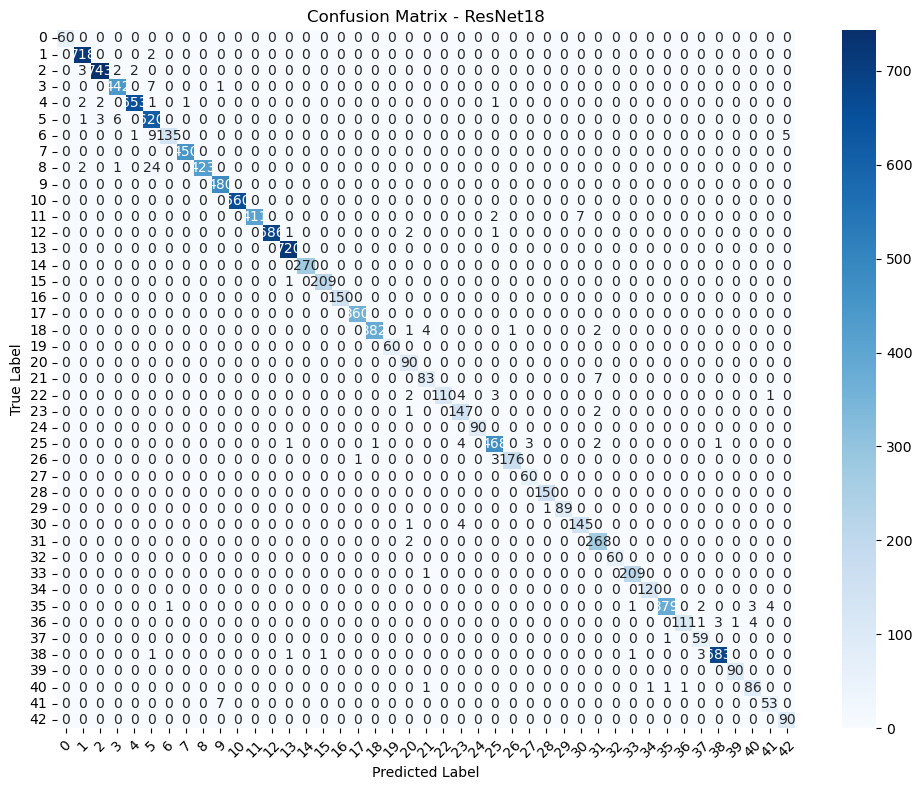

In [8]:
metrics = calculate_metrics(y_true, y_pred)
print("\nMetrics:")
for key, value in metrics.items():
  print(f"{key.capitalize()}: {value:.4f}")

print("\nClassification Report:")
print_classification_report(y_true, y_pred)

cm = get_confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(43)]

plot_confusion_matrix(cm, class_names=class_names, title="Confusion Matrix - ResNet18")